# Introduction

From our dataset, we will be using the attributes gender, region, highest_education, age_band, num_of_prev_attempts, studied_credits, imd_band$^1$, disability to predict the classifier final_result.

## Cleaning our data

###  Data Analysis
Todo:
* Frequency Bar Charts 
* Relevant summary statistics about the dataset.


Because studied_credits, and num_of_prev_attempts are numerical attributes. We will convert them to categorical. The table below denotes how studied_credits will be converted, and num_of_prev_attempts will be converted to a bool where True denotes that the class has been previously attempted, and False denotes that it has not. 

|number|credit ranges|
|------|-------------|
|1|$\leq$ 59|
|2|60-119|
|3|120-179|
|4|180-239|
|5|$\geq$ 240 |

We further cleaned our data by dropping rows with missing values. We understand that this could impact the affects of our data as we would me losing out on some entries. However, upon further inspection we came to realize that only about 1,000 of the over 30,000 rows of data contained missing values. This small ratio made us sure that losing out on this data would not have a negative impact on our classifier. 

1: imd_band is a measure of poverty based on area in the UK.



In [73]:
import importlib

from tabulate import tabulate
import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils
import pickle

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier, MyZeroRClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

student_data = MyPyTable().load_from_file("input_data/studentInfo.csv")

# remove missing values
student_data.remove_rows_with_missing_values()

gender = student_data.get_column("gender")
region = student_data.get_column("region")
highest_education = student_data.get_column("highest_education") 
age_band = student_data.get_column("age_band")
num_of_prev_attempts = student_data.get_column("num_of_prev_attempts") 
studied_credits = student_data.get_column("studied_credits")


for i in range(len(student_data.data)):
    student_data.data[i][8] = num_of_prev_attempts[i]
    student_data.data[i][9] = studied_credits[i]

imd_band = student_data.get_column("imd_band")
disability = student_data.get_column("disability")


## EDA

As can be seen in the visualization below, the "distinction" value of the class is not very prevelent. Since students who received a "distinction" final result passed the class we will include distinction into our "pass" category to try and limit our classifier domain. To make the classifier more evenly distributed, we will also include a "fail" and "withdrawn" final result as of the same class since they both have the same end result— the student does not receive credit for the course. The end result of our changes can be seen in the second bar chart below. 

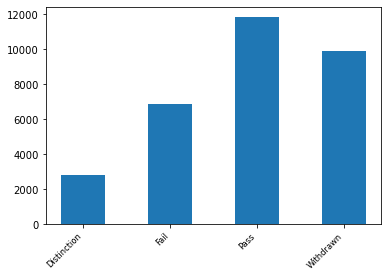

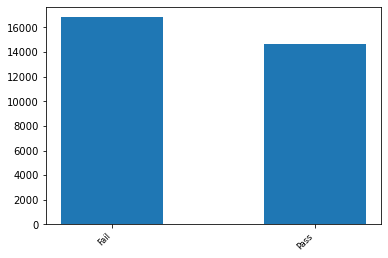

In [64]:
values, counts = myutils.get_frequencies(student_data.data, student_data.column_names, "final_result")
myutils.bar_chart(values, counts)

myutils.replace_values_in_column("Withdrawn", "Fail", student_data.data, student_data.column_names, "final_result")
myutils.replace_values_in_column("Distinction", "Pass", student_data.data, student_data.column_names, "final_result")

values, counts = myutils.get_frequencies(student_data.data, student_data.column_names, "final_result")
myutils.bar_chart(values, counts)
final_result = student_data.get_column("final_result")

student_data.save_to_file('output_data/clean_data.csv')

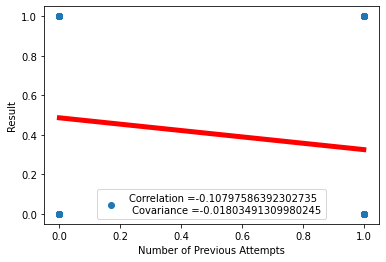

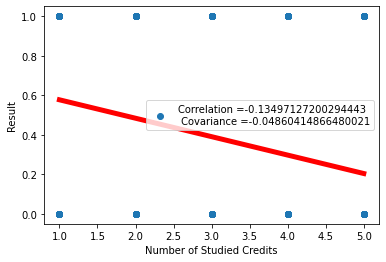

In [70]:
numeric_result = myutils.convert_bool_to_numerical_value(final_result, ["Pass", "Fail"])
slope, y_int = myutils.calculate_linear_regression(num_of_prev_attempts, numeric_result)
myutils.scatter_plot(num_of_prev_attempts, numeric_result, slope, y_int, "Number of Previous Attempts", "Result")

slope, y_int = myutils.calculate_linear_regression(studied_credits, numeric_result)
myutils.scatter_plot(studied_credits, numeric_result, slope, y_int, "Number of Studied Credits", "Result")

myutils.convert_vals_into_cutoffs(num_of_prev_attempts, [0, 1], [False, True])
myutils.convert_vals_into_cutoffs(studied_credits, [59, 60, 120, 180, 240,], [1,2,3,4,5])

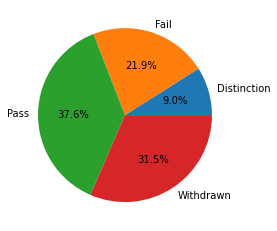

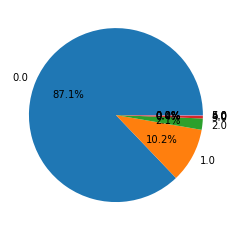

In [79]:
result_vals, result_counts = myutils.get_frequencies(student_data.data, student_data.column_names, "final_result")
myutils.pie_chart(result_vals, result_counts)

myutils.histogram(num_of_prev_attempts) 

## Classifications

### Accuracy Rates
For the purposes of this demo, we ran our, now clean, data through our decisions tree classifiers and naive bayes classifier. Naive Bayes is a bit more accurate than decision tree and our accuracy was a bit disappointing. We are hoping that our RandomForestClassifier will solve some of the overfitting and improve our accuracy rate for our final project.  

In [55]:
outfile = open("output_data/accuracies.txt", "w")
# get a smaller subsection of data to run tests over
student_attributes = [x[3:11] for x in student_data.data]
subsample, _ = myevaluation.random_stratified_test_remainder_set(student_attributes, final_result, 3, set_size=0.33)

subsample_attributes = [x[:8] for x in subsample]
subsample_result = [x[-1] for x in subsample]
student_train_folds, student_test_folds = myevaluation.stratified_kfold_cross_validation(subsample_attributes, subsample_result, 10) 

student_test = []
student_train = []

final_results_test = []
final_results_train = []

# turn indexes into data sets
for row in student_train_folds:
    student_set = []
    final_results_set = []
    for item in row:
        student_set.append(subsample_attributes[item])
        final_results_set.append(subsample_result[item])
    student_train.append(student_set)
    final_results_train.append(final_results_set)

# turn indexes into data sets
for row in student_test_folds:
    student_set = []
    final_results_set = []
    for item in row:
        student_set.append(subsample_attributes[item])
        final_results_set.append(subsample_result[item])
    student_test.append(student_set)
    final_results_test.append(final_results_set)
outfile.write("===========================================\nPredictive Accuracy\n===========================================\nStratified 10-Fold Cross Validation")
print("===========================================")
print("Predictive Accuracy")
print("===========================================")
print("Stratified 10-Fold Cross Validation")

# Zero Rules Classifier
total_zr = []
total_expected_zr = []
for i in range(10):
    student_zr = MyZeroRClassifier()
    student_zr.fit(final_results_train[i])
    zr_predictions = student_zr.predict(student_test[i])
    total_zr.extend(zr_predictions)
    total_expected_zr.extend(final_results_test[i])

accuracy, errorrate = myutils.accuracy_errorrate(total_zr, total_expected_zr)
print("Zero Rules Classifier: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nZero Rules Classifier: accuracy = " +  str(accuracy) + " error rate = " + str(errorrate))
# Naive Bayes model
total_Naive = []
total_expected = []
for i in range(10):
    student_Naive = MyNaiveBayesClassifier()    
    student_Naive.fit(student_train[i],final_results_train[i])
    Naive_predictions = student_Naive.predict(student_test[i])
    total_Naive.extend(Naive_predictions)
    total_expected.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_Naive, total_expected)
print("Naive Bayes: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nNaive Bayes: accuracy = " + str(accuracy) +  " error rate = " + str(errorrate))

#Tree model
total_tree = []
total_expected = []
for i in range(10):
    student_tree = MyDecisionTreeClassifier()    
    student_tree.fit(student_train[i],final_results_train[i])
    tree_predictions = student_tree.predict(student_test[i])
    total_tree.extend(tree_predictions)
    total_expected.extend(final_results_test[i])



accuracy, errorrate = myutils.accuracy_errorrate(total_tree, total_expected)
print("Tree: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nTree: accuracy = " + str(accuracy) + " error rate = " + str(errorrate))

#Random Forest Model
total_random_forest = []
total_expected_forest = []
for i in range(10):
    student_random_forest = MyRandomForestClassifier()    
    student_random_forest.fit(student_train[i],final_results_train[i], 5, 20, 7, 3)
    forest_predictions = student_random_forest.predict(student_test[i])
    total_random_forest.extend(forest_predictions)
    total_expected_forest.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_random_forest, total_expected_forest)
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nRandom Forest: accuracy = " + str(accuracy) + " error rate = "+ str(errorrate))

Predictive Accuracy
Stratified 10-Fold Cross Validation
Zero Rules Classifier: accuracy =  0.5344959024204308 error rate =  0.4655040975795693
Naive Bayes: accuracy =  0.6032018296169239 error rate =  0.396798170383076
Tree: accuracy =  0.5547932151705737 error rate =  0.4452067848294263
Random Forest: accuracy =  0.5873832666285497 error rate =  0.41261673337145033


78

### Confusion Matrix

We then made a confusion matrix for our decision tree classifier to see how our predicitions were distributed. It shows how the predictions are not clustered along the diagonal and this is due to the classifier's inaccuracies. 

In [56]:
tree_matrix = myevaluation.confusion_matrix(total_expected, total_tree, ["Pass","Fail"])

for i in range(len(tree_matrix)):
    total = 0
    rec = 0
    for item in tree_matrix[i]:
        total += item
    true_pos = tree_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    tree_matrix[i].append(total)
    tree_matrix[i].append(rec)

tree_matrix[0].insert(0, "Pass")
tree_matrix[1].insert(0, "Fail")

print("Decision Tree (Stratified 10 Fold Cross Validation Results)")
print(tabulate(tree_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nDecision Tree (Stratified 10 Fold Cross Validation Results)\n")
outfile.write(tabulate(tree_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))


Decision Tree (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass              2472    2413     4885          50.6039
Fail              2259    3350     5609          59.7254


227

In [57]:
random_matrix = myevaluation.confusion_matrix(total_expected_forest, total_random_forest, ["Pass","Fail"])

for i in range(len(random_matrix)):
    total = 0
    rec = 0
    for item in random_matrix[i]:
        total += item
    true_pos = random_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    random_matrix[i].append(total)
    random_matrix[i].append(rec)

random_matrix[0].insert(0, "Pass")
random_matrix[1].insert(0, "Fail")

print("Random Forest (Stratified 10 Fold Cross Validation Results)")
print("F = 5, N = 20, M = 7")
print(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nRandom Forest (Stratified 10 Fold Cross Validation Results)\nF = 5, N = 20, M = 7\n")
outfile.write(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))

Random Forest (Stratified 10 Fold Cross Validation Results)
F = 5, N = 20, M = 7
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass              2632    2253     4885          53.8792
Fail              2077    3532     5609          62.9702


227

## Variations of F, M, and N

In [58]:
#Random Forest Model
total_random_forest = []
total_expected_forest = []
# F = 5, N = 5, M = 3
for i in range(10):
    student_random_forest = MyRandomForestClassifier()    
    student_random_forest.fit(student_train[i],final_results_train[i], 5, 5, 3, 3)
    forest_predictions = student_random_forest.predict(student_test[i])
    total_random_forest.extend(forest_predictions)
    total_expected_forest.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_random_forest, total_expected_forest)
print("F = 5, N = 5, M = 3")
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nF = 5, N = 5, M = 3\nRandom Forest: accuracy = " + str(accuracy) + " error rate = "+ str(errorrate))

random_matrix = myevaluation.confusion_matrix(total_expected_forest, total_random_forest, ["Pass","Fail"])

for i in range(len(random_matrix)):
    total = 0
    rec = 0
    for item in random_matrix[i]:
        total += item
    true_pos = random_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    random_matrix[i].append(total)
    random_matrix[i].append(rec)

random_matrix[0].insert(0, "Pass")
random_matrix[1].insert(0, "Fail")

print()
print("Random Forest (Stratified 10 Fold Cross Validation Results)")
print(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nRandom Forest (Stratified 10 Fold Cross Validation Results)\n")
outfile.write(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))


F = 5, N = 5, M = 3
Random Forest: accuracy =  0.5787116447493806 error rate =  0.4212883552506194

Random Forest (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass              2413    2472     4885          49.3961
Fail              1949    3660     5609          65.2523


227

In [59]:
#Random Forest Model
total_random_forest = []
total_expected_forest = []
# F = 5, N = 50, M = 10
for i in range(10):
    student_random_forest = MyRandomForestClassifier()    
    student_random_forest.fit(student_train[i],final_results_train[i], 5, 50, 10, 3)
    forest_predictions = student_random_forest.predict(student_test[i])
    total_random_forest.extend(forest_predictions)
    total_expected_forest.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_random_forest, total_expected_forest)
print("F = 5, N = 50, M = 10")
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nF = 5, N = 50, M = 10\nRandom Forest: accuracy = " + str(accuracy) + " error rate = "+ str(errorrate))

random_matrix = myevaluation.confusion_matrix(total_expected_forest, total_random_forest, ["Pass","Fail"])

for i in range(len(random_matrix)):
    total = 0
    rec = 0
    for item in random_matrix[i]:
        total += item
    true_pos = random_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    random_matrix[i].append(total)
    random_matrix[i].append(rec)

random_matrix[0].insert(0, "Pass")
random_matrix[1].insert(0, "Fail")

print()
print("Random Forest (Stratified 10 Fold Cross Validation Results)")
print(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nRandom Forest (Stratified 10 Fold Cross Validation Results)\n")
outfile.write(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))


F = 5, N = 50, M = 10
Random Forest: accuracy =  0.5834762721555175 error rate =  0.41652372784448255

Random Forest (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass              2649    2236     4885          54.2272
Fail              2135    3474     5609          61.9362


227

In [60]:
#Random Forest Model
total_random_forest = []
total_expected_forest = []
# F = 8, N = 20, M = 7
for i in range(10):
    student_random_forest = MyRandomForestClassifier()    
    student_random_forest.fit(student_train[i],final_results_train[i], 5, 8, 20, 7)
    forest_predictions = student_random_forest.predict(student_test[i])
    total_random_forest.extend(forest_predictions)
    total_expected_forest.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_random_forest, total_expected_forest)
print("F = 8, N = 20, M = 7")
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nF = 8, N = 20, M = 7\nRandom Forest: accuracy = " + str(accuracy) + " error rate = "+ str(errorrate))

random_matrix = myevaluation.confusion_matrix(total_expected_forest, total_random_forest, ["Pass","Fail"])

for i in range(len(random_matrix)):
    total = 0
    rec = 0
    for item in random_matrix[i]:
        total += item
    true_pos = random_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    random_matrix[i].append(total)
    random_matrix[i].append(rec)

random_matrix[0].insert(0, "Pass")
random_matrix[1].insert(0, "Fail")

print()
print("Random Forest (Stratified 10 Fold Cross Validation Results)")
print(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nRandom Forest (Stratified 10 Fold Cross Validation Results)\n")
outfile.write(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))


F = 8, N = 20, M = 7
Random Forest: accuracy =  0.5507909281494188 error rate =  0.4492090718505813

Random Forest (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass              2363    2522     4885          48.3726
Fail              2192    3417     5609          60.92


225

In [61]:
#Random Forest Model
total_random_forest = []
total_expected_forest = []
# F = 3, N = 20, M = 7
for i in range(10):
    student_random_forest = MyRandomForestClassifier()    
    student_random_forest.fit(student_train[i],final_results_train[i], 3, 20, 7, 3)
    forest_predictions = student_random_forest.predict(student_test[i])
    total_random_forest.extend(forest_predictions)
    total_expected_forest.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_random_forest, total_expected_forest)
print("F = 3, N = 20, M = 7")
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nF = 3, N = 20, M = 7\nRandom Forest: accuracy = " + str(accuracy) + " error rate = "+ str(errorrate))

random_matrix = myevaluation.confusion_matrix(total_expected_forest, total_random_forest, ["Pass","Fail"])

for i in range(len(random_matrix)):
    total = 0
    rec = 0
    for item in random_matrix[i]:
        total += item
    true_pos = random_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    random_matrix[i].append(total)
    random_matrix[i].append(rec)

random_matrix[0].insert(0, "Pass")
random_matrix[1].insert(0, "Fail")

print()
print("Random Forest (Stratified 10 Fold Cross Validation Results)")
print(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nRandom Forest (Stratified 10 Fold Cross Validation Results)\n")
outfile.write(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))


F = 3, N = 20, M = 7
Random Forest: accuracy =  0.5897655803316181 error rate =  0.4102344196683819

Random Forest (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass              2408    2477     4885          49.2938
Fail              1828    3781     5609          67.4095


227

In [62]:
student_random_forest = MyRandomForestClassifier()    
student_random_forest.fit(subsample_attributes,subsample_result, 5, 20, 7, 3)
X_train, X_test, y_train, y_test = myevaluation.train_test_split(subsample_attributes, subsample_result)
predicted = student_random_forest.predict(X_test)
accuracy, errorrate = myutils.accuracy_errorrate(predicted, y_test)
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)
outfile.write("\nRandom Forest: accuracy = " + str(accuracy) + " error rate = "+ str(errorrate))

random_matrix = myevaluation.confusion_matrix(y_test, predicted, ["Pass","Fail"])

for i in range(len(random_matrix)):
    total = 0
    rec = 0
    for item in random_matrix[i]:
        total += item
    true_pos = random_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    random_matrix[i].append(total)
    random_matrix[i].append(rec)

random_matrix[0].insert(0, "Pass")
random_matrix[1].insert(0, "Fail")

print()
print("Random Forest (Stratified 10 Fold Cross Validation Results)")
print(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.write("\nRandom Forest (Stratified 10 Fold Cross Validation Results)\n")
outfile.write(tabulate(random_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))
outfile.close()


Random Forest: accuracy =  0.6229792147806005 error rate =  0.3770207852193995

Random Forest (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass               871     738     1609          54.133
Fail               568    1287     1855          69.3801


In [ ]:
packaged_object = [student_data.column_names[3:11], student_random_forest.forest]
# pickle packaged_object
outfile = open("forest.p", "wb")
pickle.dump(packaged_object, outfile)
outfile.close()

# Conclusion 
## Dataset Challenges
We used a dataset that included student attributes such as gender, region, highest education, age group, previous attempts at the course, number of credits, poverty level by region, and disability to predict the whether or not they passed the course. 

Some challenges that we faced included the size of our dataset. It had 30,000 entries so in order to make this data mineable on our machines we had to create a stratified-subsample. Another challenge was with the uneven distribution of classifier results. The original classifier included the results of Withdrawn, Distinction, Pass, and Fail. We solved this by including Distinction as a subset of Pass and Withdrawn as a subset of Fail. We also had to adjust a few continuous attributes to be categorical such as studied_credits and num_of_prev_attempts. 

## Classification Approach
We used the Zero-R classifier as a baseline for our accuracy rates. We then further explored how to improve this by looking at a single decision tree and Naive Bayes. All of these classifiers ended up having similar results to RandomForest which were somewhere between 52% and 61% accurate. Our most accurate classifier was the RandomForest classifier when ran over the entire dataset with values of F = 5, N = 20, and M = 7. 

## Ways to Improve
One way to potentially improve this classifier's results with our dataset would be to explore correlation between attributes to more affectively choose subsets of attributes (for our F value). This could be done with rule mining to see the groupings of attributes before creating the tree. 

It is also important to note that we used 8 attributes for our classifier which may have caused for some overfitting. We found these attributes important to our data analysis but the classifier's accuracy may have improved if we had chosen a smaller set of attributes from the table based on their correlation with final_result. 


